<a href="https://colab.research.google.com/github/koeyhnim/banghak/blob/chap-6/my_notebook_chap6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

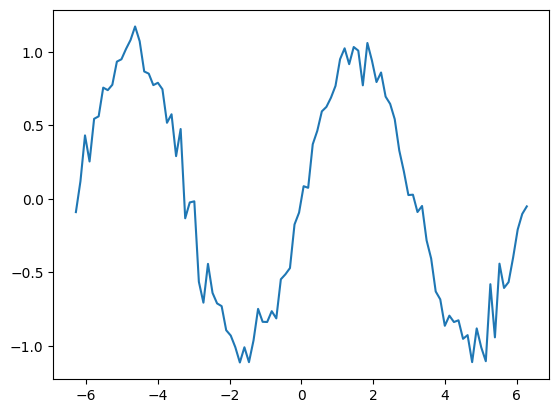

In [1]:
import torch
import math
import matplotlib.pyplot as plt

sin_x = torch.linspace(-2*math.pi, 2*math.pi, 100)  # -2π부터 2π까지
sin_y = torch.sin(sin_x)  + 0.1*torch.randn(len(sin_x))  # sin 함수에 난수로 노이즈를 더한다
plt.plot(sin_x, sin_y)
plt.show()

In [2]:
from torch.utils.data import TensorDataset, DataLoader

n_time = 10  # 시각의 수
n_sample = len(sin_x)-n_time  # 샘플 수

input_data = torch.zeros((n_sample, n_time, 1))  # 입력
correct_data = torch.zeros((n_sample, 1))  # 정답
for i in range(n_sample):
    input_data[i] = sin_y[i:i+n_time].view(-1, 1)  #  (시각의 수, 입력의 수)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 정답은 입력보다도 1개 뒤

dataset = TensorDataset(input_data, correct_data)  # 데이터셋의 작성
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # DataLoader의 설정

In [3]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(  # RNN 층
            input_size=1,  # 입력 수
            hidden_size=64,  # 뉴런 수
            batch_first=True,  # 입력의 형태를 (배치 크기, 시각 수, 입력 수)로 한다
        )
        self.fc = nn.Linear(64, 1)  # 전결합층

    def forward(self, x):
        # y_rnn:전시각의 출력  h:중간층의 최후 시각의 값
        y_rnn, h = self.rnn(x, None)
        y = self.fc(y_rnn[:, -1, :])  # -1로 최후 시각만 취득하여 전결합에 건넨다
        return y

net = Net()
print(net)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Epoch: 0 Loss_Train: 0.4500814701120059


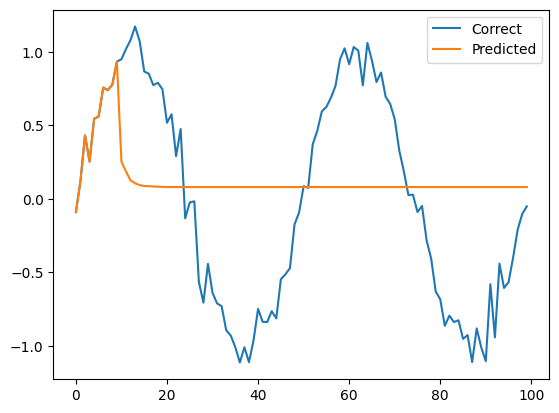

Epoch: 10 Loss_Train: 0.04648006288334727


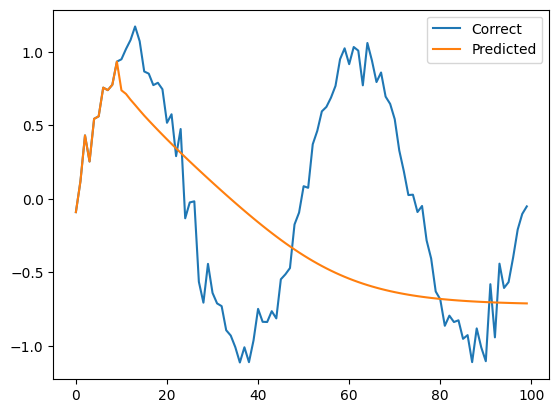

Epoch: 20 Loss_Train: 0.03298280776167909


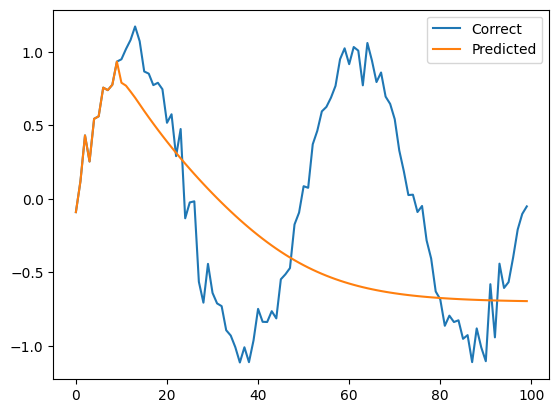

Epoch: 30 Loss_Train: 0.024628107397196192


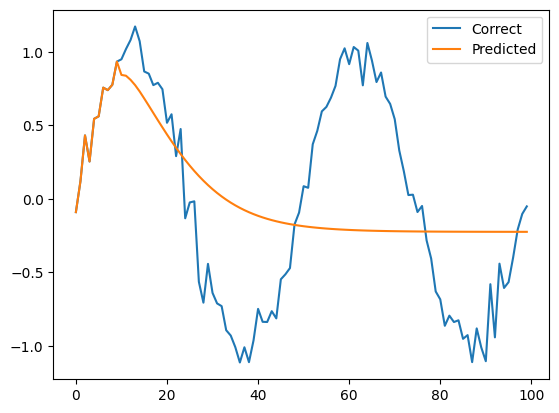

Epoch: 40 Loss_Train: 0.020135618979111314


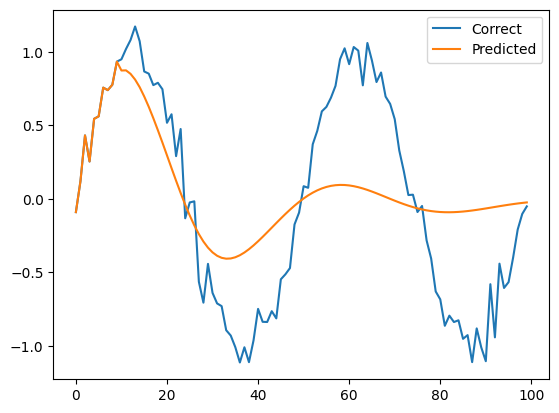

Epoch: 50 Loss_Train: 0.020067916018888354


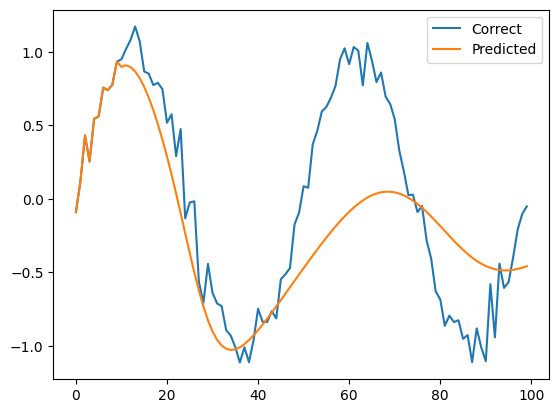

Epoch: 60 Loss_Train: 0.01955324471540128


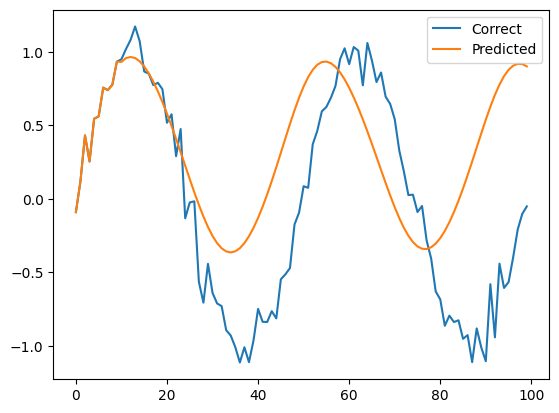

Epoch: 70 Loss_Train: 0.020304169195393722


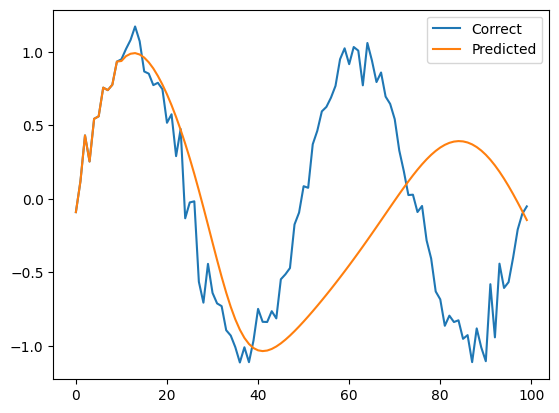

Epoch: 80 Loss_Train: 0.01837902337623139


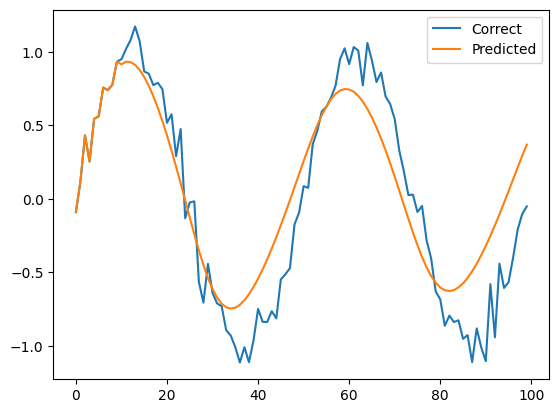

Epoch: 90 Loss_Train: 0.018273427907843143


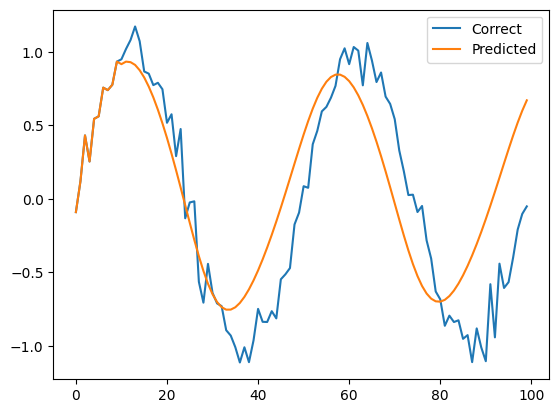

Epoch: 99 Loss_Train: 0.01868926244787872


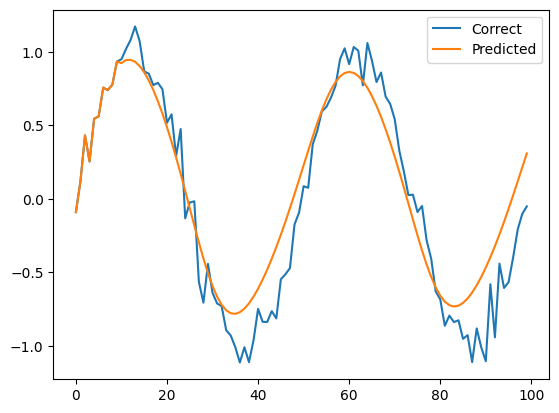

In [4]:
from torch import optim

# 평균 제곱 오차
loss_fnc = nn.MSELoss()

# 최적화 알고리즘
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 학습률은 0.01

# 손실의 로그
record_loss_train = []

# 학습
epochs = 100  # 에포크 수
for i in range(epochs):
    net.train()  # 훈련 모드
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # 미니배치 (x, t)를 꺼낸다
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    # 경과 표시
    if i%10==0 or i==epochs-1:
        net.eval()  # 평가 모드
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0].view(-1)) # 처음의 입력
        for i in range(n_sample):
            x = torch.tensor(predicted[-n_time:])  # 가장 최근의 시계열을 꺼낸다
            x = x.view(1, n_time, 1)  # (배치 크기, 시각 수, 입력 수)
            y = net(x)
            predicted.append(y[0].item())  # 예측 결과를 predicted에 추가한다

        plt.plot(range(len(sin_y)), sin_y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()


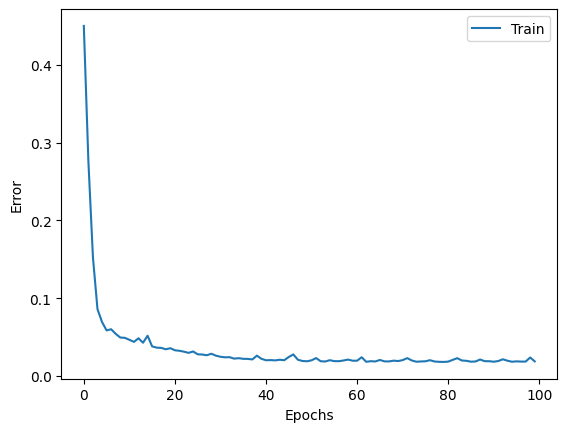

In [5]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.28MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.68MB/s]


데이터의 수: 60000


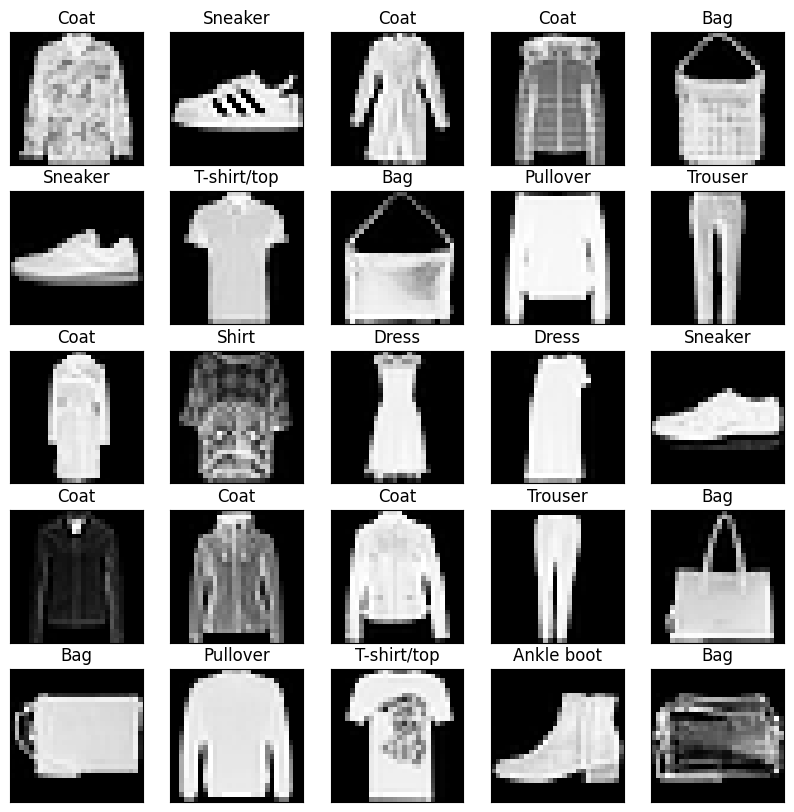

In [1]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

fmnist_data = FashionMNIST(root="./data",
                            train=True,download=True,
                            transform=transforms.ToTensor())
fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
print("데이터의 수:", len(fmnist_data))

n_image = 25  # 표시하는 이미지의 수
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image, shuffle=True)
dataiter = iter(fmnist_loader)  # 이터레이터
images, labels = next(dataiter)  # 처음의 배치를 꺼낸다

img_size = 28
plt.figure(figsize=(10,10))  # 이미지의 표시 크기
for i in range(n_image):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(images[i].view(img_size, img_size), cmap="Greys_r")
    label = fmnist_classes[labels[i]]
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)  # 축을 비표시로
    ax.get_yaxis().set_visible(False)

plt.show()

In [2]:
import torch
from torch.utils.data import TensorDataset

n_time = 14  # 시각 수
n_in = img_size  # 입력층의 뉴런 수
n_mid = 256  # 중간층의 뉴런 수
n_out = img_size  # 출력층의 뉴런 수
n_sample_in_img = img_size-n_time  # 1장의 이미지 안의 샘플 수

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # 이터레이터
train_imgs, labels = next(dataiter)  # 데이터를 꺼낸다
train_imgs = train_imgs.view(-1, img_size, img_size)

n_sample = len(train_imgs) * n_sample_in_img  # 샘플 수

input_data = torch.zeros((n_sample, n_time, n_in))  # 입력
correct_data = torch.zeros((n_sample, n_out))  # 정답
for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i*n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j+n_time]
        correct_data[sample_id] = train_imgs[i, j+n_time]

dataset = TensorDataset(input_data, correct_data)  # 데이터셋의 작성
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoader의 설정

In [3]:
n_disp = 10  # 생성하고 표시하는 이미지의 수

disp_data = FashionMNIST(root="./data",
                            train=False,download=True,
                            transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # 이터레이터
disp_imgs, labels = next(dataiter)  # 데이터를 꺼낸다
disp_imgs = disp_imgs.view(-1, img_size, img_size)

In [4]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(  # LSTM 층
            input_size=n_in,  # 입력 크기
            hidden_size=n_mid,  # 뉴런 수
            batch_first=True,  # 입력을 (배치 크기, 시각 수, 입력 수)로 한다
        )
        self.fc = nn.Linear(n_mid, n_out)  # 전결합층

    def forward(self, x):
        # y_rnn: 전시각의 출력 h: 중간층의 최후 시각의 값  c: 기억 셀
        y_rnn, (h, c) = self.rnn(x, None)
        y = self.fc(y_rnn[:, -1, :])  # y는 최후 시각의 출력
        return y

net = Net()
net.cuda()  # GPU 대응
print(net)

Net(
  (rnn): LSTM(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)


In [5]:
def generate_images():
    # 오리지널 이미지
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
        ax.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 축을 비표시로
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 아랫 부분을 RNN에 의해 생성한 이미지
    print("Generated:")
    net.eval()  # 평가 모드
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].view(1, n_time, img_size)
            x = x.cuda()  # GPU 대응
            gen_imgs[i, j+n_time] = net(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
        ax.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 축을 비표시로
        ax.get_yaxis().set_visible(False)
    plt.show()

Epoch: 0 Loss_Train: 0.017511079364142486
Original:


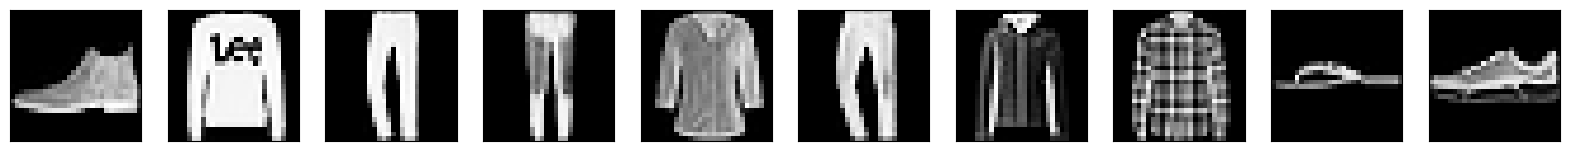

Generated:


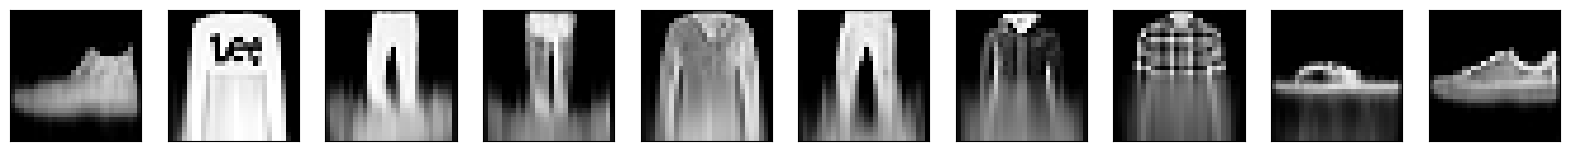

Epoch: 5 Loss_Train: 0.011111649794655317
Original:


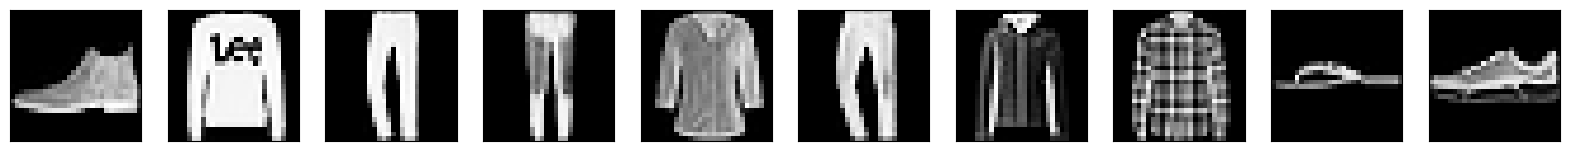

Generated:


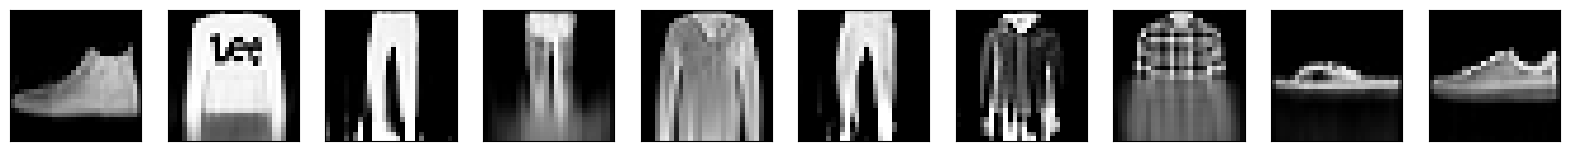

Epoch: 10 Loss_Train: 0.01014042125469062
Original:


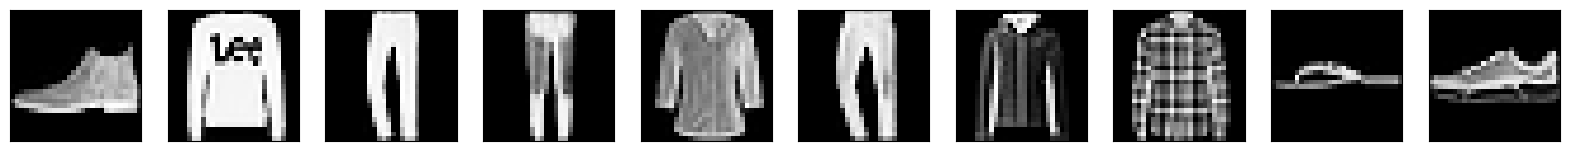

Generated:


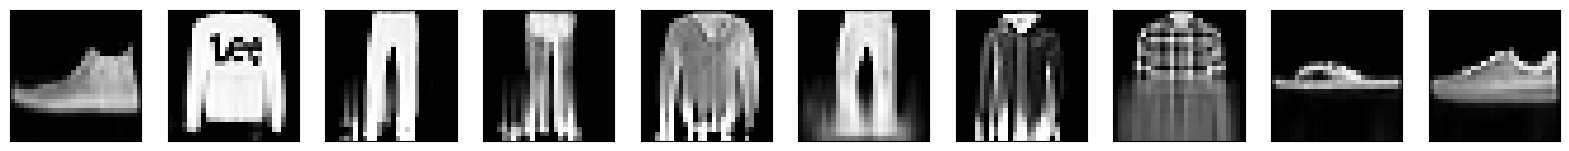

Epoch: 15 Loss_Train: 0.00956542427468101
Original:


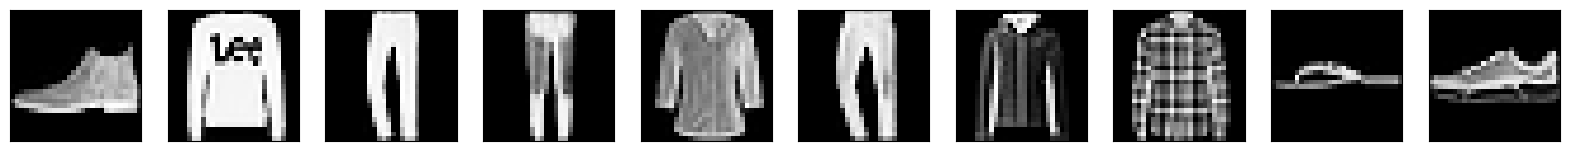

Generated:


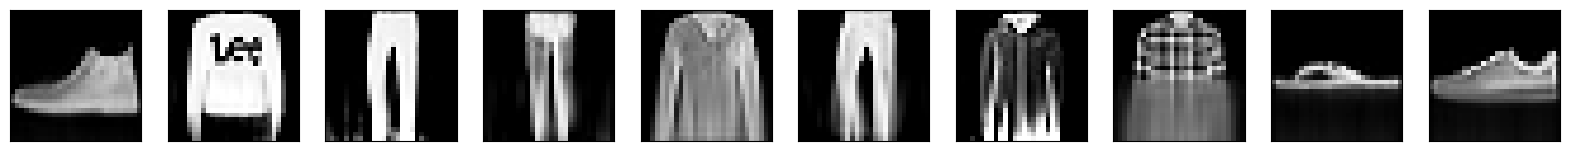

Epoch: 20 Loss_Train: 0.009164920172726606
Original:


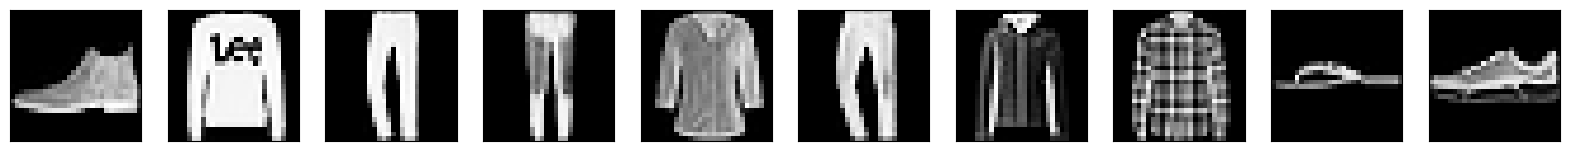

Generated:


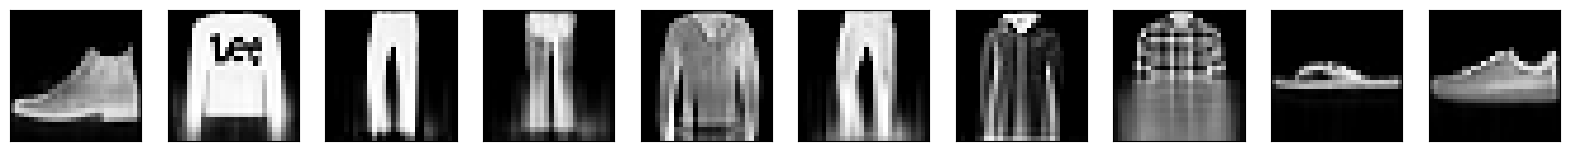

Epoch: 25 Loss_Train: 0.00886768157094826
Original:


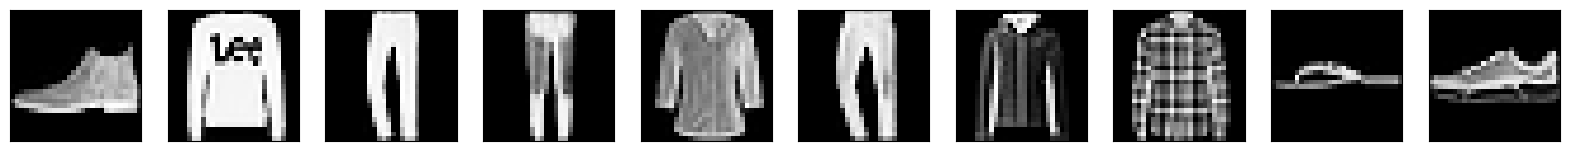

Generated:


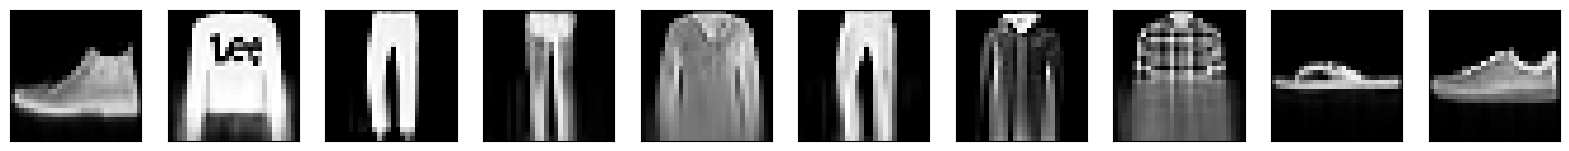

Epoch: 29 Loss_Train: 0.008676791231998097
Original:


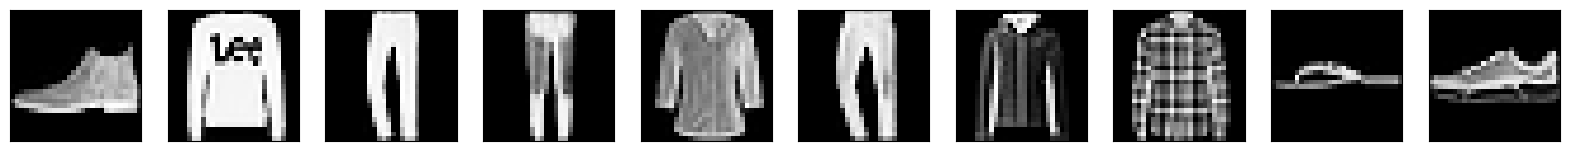

Generated:


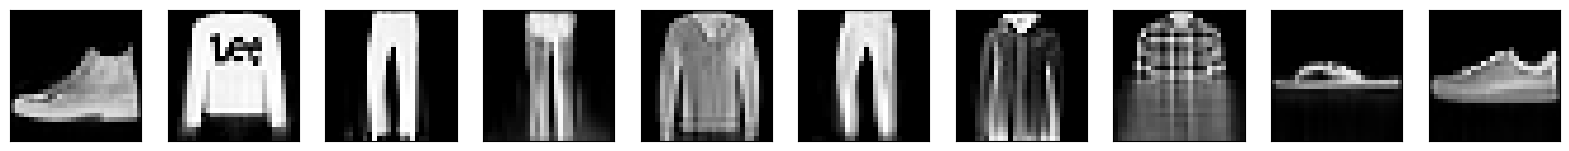

In [6]:
from torch import optim

# 평균 제곱 오차
loss_fnc = nn.MSELoss()

# 최적화 알고리즘
optimizer = optim.Adam(net.parameters())

# 손실의 로그
record_loss_train = []

# 학습
epochs = 30  # 에포크 수
for i in range(epochs):
    net.train()  # 훈련 모드
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # 미니배치 (x, t)를 꺼낸다
        x, t = x.cuda(), t.cuda()  # GPU 대응
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%5==0 or i==epochs-1:
        print("Epoch:", i, "Loss_Train:", loss_train)
        generate_images()

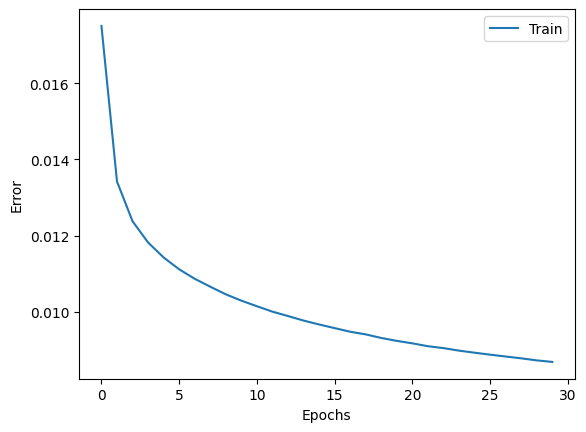

In [7]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [8]:
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

img_size = 28
n_time = 14  # 시각 수
n_in = img_size  # 입력층의 뉴런 수
n_mid = 256  # 중간층의 뉴런 수
n_out = img_size  # 출력층의 뉴런 수
n_sample_in_img = img_size-n_time  # 1장의 이미지 안의 샘플 수

fmnist_data = FashionMNIST(root="./data",
                            train=True,download=True,
                            transform=transforms.ToTensor())
fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # 이터레이터
train_imgs, labels = next(dataiter)  # 데이터를 꺼낸다
train_imgs = train_imgs.view(-1, img_size, img_size)

n_sample = len(train_imgs) * n_sample_in_img  # 샘플 수

input_data = torch.zeros((n_sample, n_time, n_in))  # 입력
correct_data = torch.zeros((n_sample, n_out))  # 정답
for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i*n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j+n_time]
        correct_data[sample_id] = train_imgs[i, j+n_time]

dataset = TensorDataset(input_data, correct_data)  # 데이터셋의 작성
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoader의 설정

In [9]:
n_disp = 10  # 생성하고 표시하는 이미지의 수

disp_data = FashionMNIST(root="./data",
                            train=False,download=True,
                            transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # 이터레이터
disp_imgs, labels = next(dataiter)  # 데이터를 꺼낸다
disp_imgs = disp_imgs.view(-1, img_size, img_size)

In [10]:
import torch.nn as nn

class Net(nn.Module):
    # ------- 이하에 코드를 적는다 -------
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(  # GRU 층
            input_size=n_in,  # 입력 크기
            hidden_size=n_mid,  # 뉴런 수
            batch_first=True,  # 입력을 (배치 크기, 시계열 수, 입력 수)로 한다
        )
        self.fc = nn.Linear(n_mid, n_out)  # 전결합층

    def forward(self, x):
        # y_rnn:전시각의 출력  h: 중간층의 최후 시각의 값
        y_rnn, h = self.rnn(x, None)
        y = self.fc(y_rnn[:, -1, :])  # y는 최후 시각의 출력
        return y
    # ------- 여기까지 -------

net = Net()
net.cuda()  # GPU 대응
print(net)

Net(
  (rnn): GRU(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)


In [11]:
def generate_images():
    # 오리지널 이미지
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
        ax.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 축을 비표시로
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 아랫부분을 RNN에 의해 생성한 이미지
    print("Generated:")
    net.eval()  # 평가 모드
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].view(1, n_time, img_size)
            x = x.cuda()  # GPU 대응
            gen_imgs[i, j+n_time] = net(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
        ax.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 축을 비표시로
        ax.get_yaxis().set_visible(False)
    plt.show()

Epoch: 0 Loss_Train: 0.01732155771816211
Original:


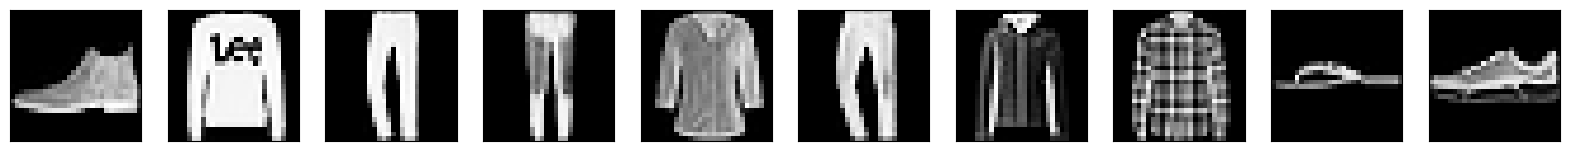

Generated:


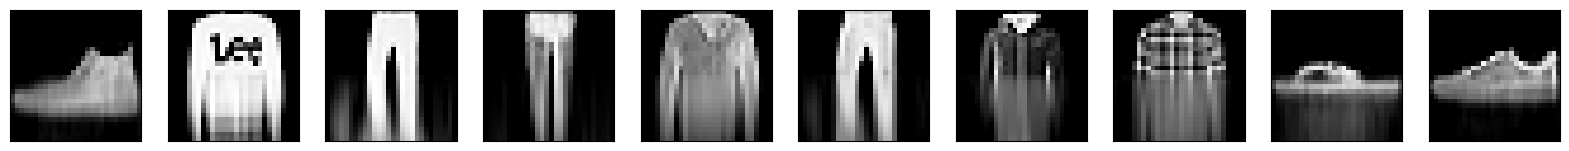

Epoch: 5 Loss_Train: 0.011556528019729468
Original:


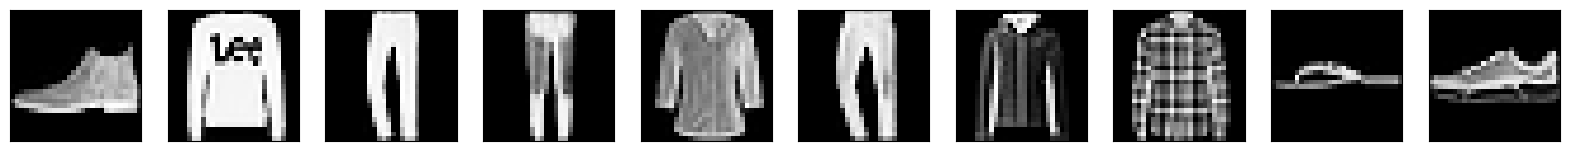

Generated:


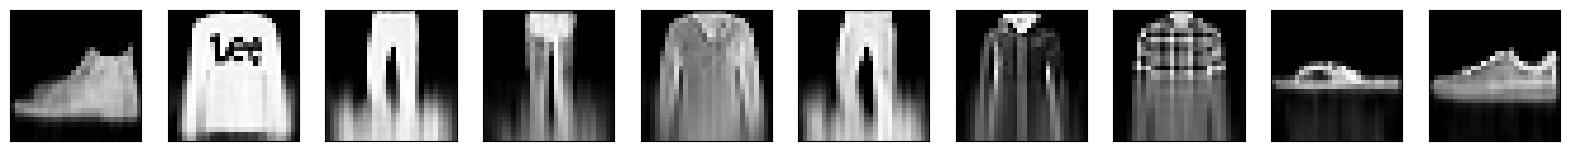

Epoch: 10 Loss_Train: 0.01078752640590217
Original:


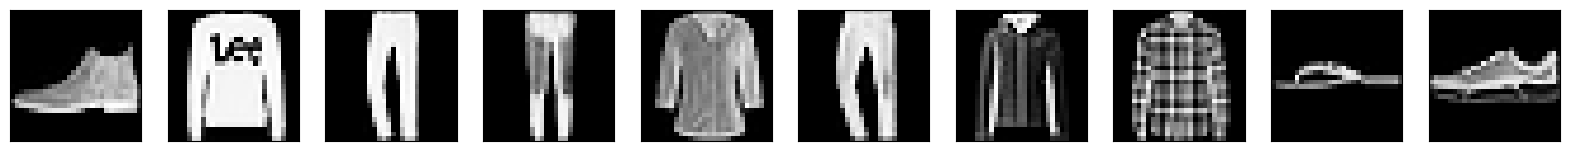

Generated:


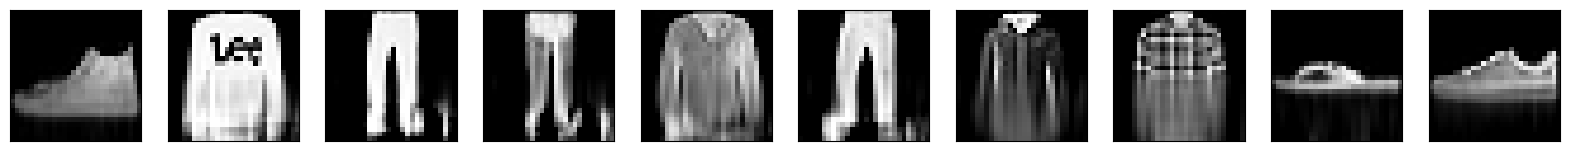

Epoch: 15 Loss_Train: 0.010367007116538375
Original:


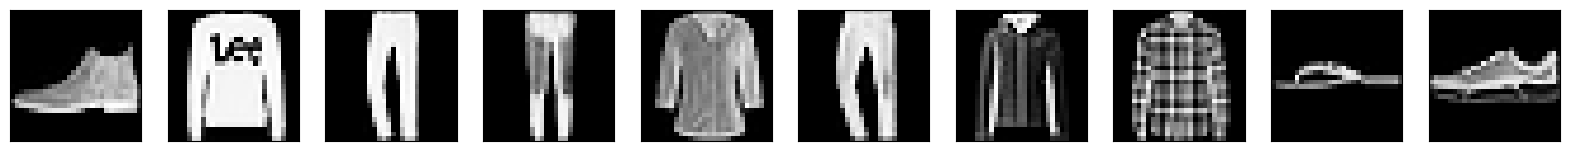

Generated:


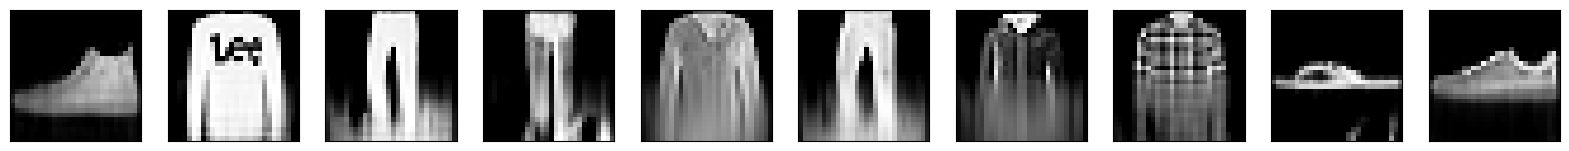

Epoch: 20 Loss_Train: 0.010083784949024236
Original:


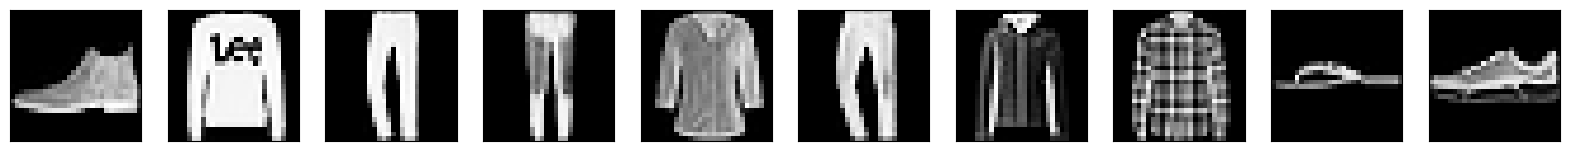

Generated:


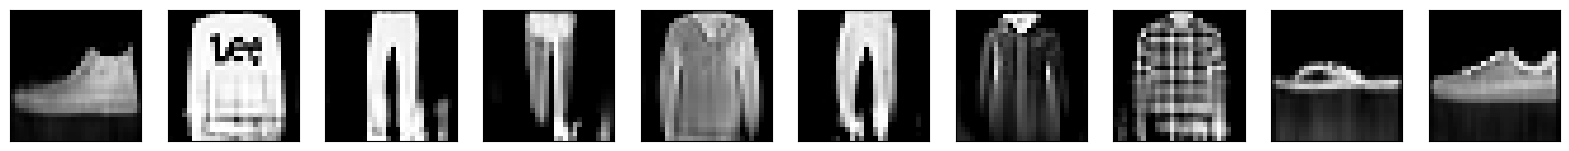

Epoch: 25 Loss_Train: 0.009872983781453128
Original:


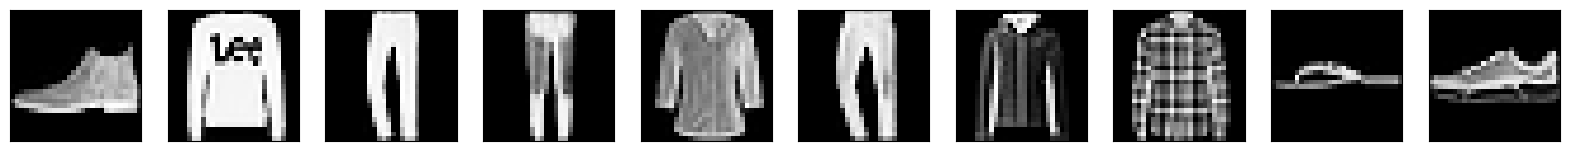

Generated:


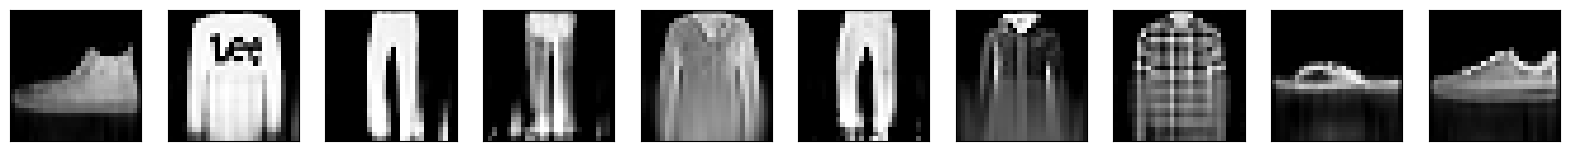

Epoch: 30 Loss_Train: 0.009718253604333229
Original:


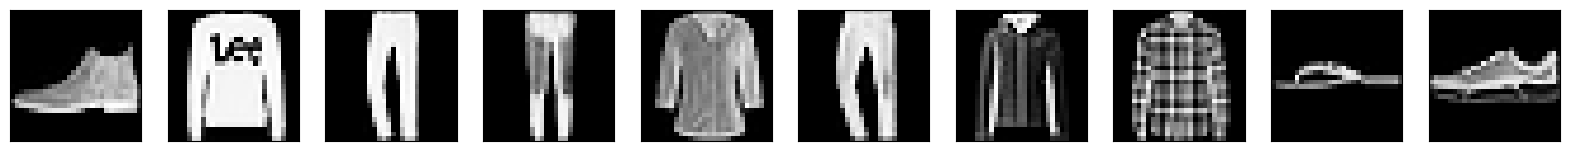

Generated:


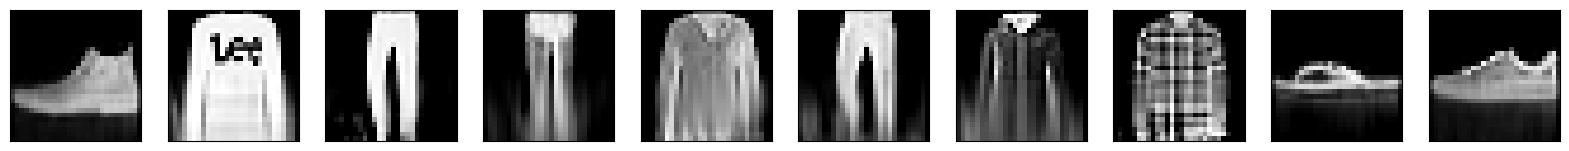

Epoch: 35 Loss_Train: 0.009604974963953291
Original:


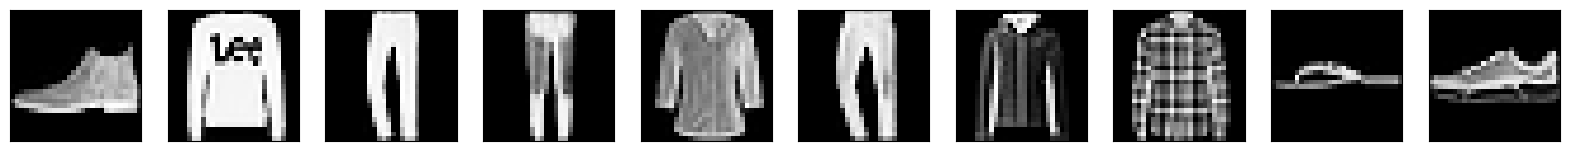

Generated:


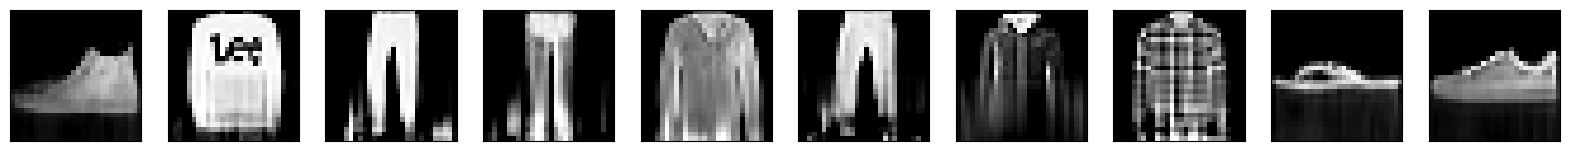

Epoch: 40 Loss_Train: 0.009560466535334364
Original:


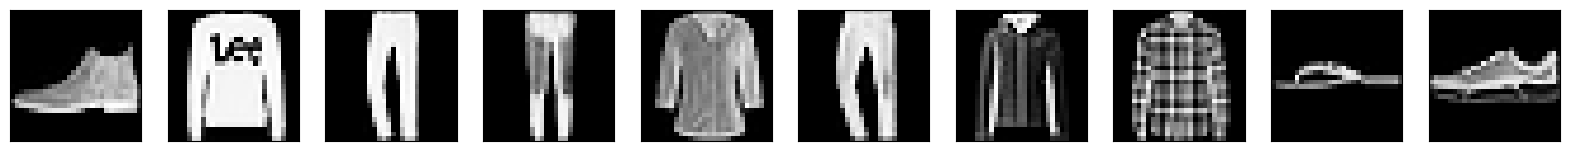

Generated:


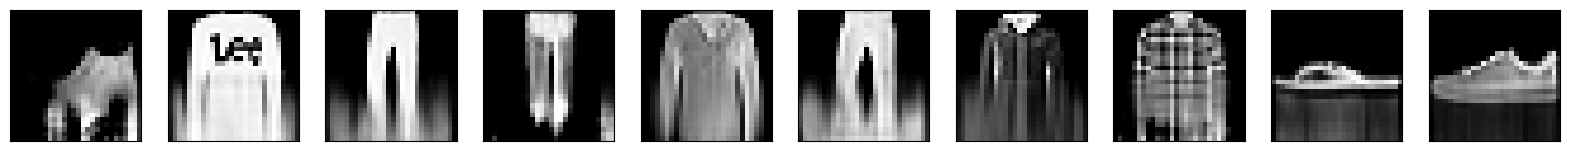

Epoch: 45 Loss_Train: 0.009410905377374846
Original:


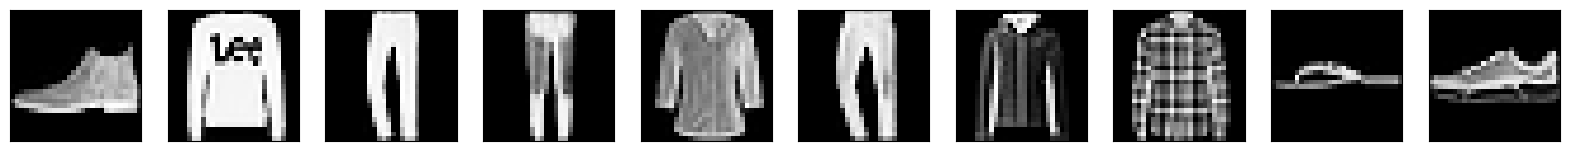

Generated:


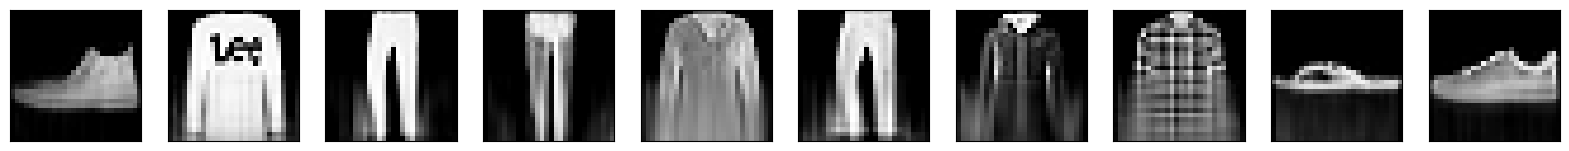

Epoch: 49 Loss_Train: 0.00933097855910391
Original:


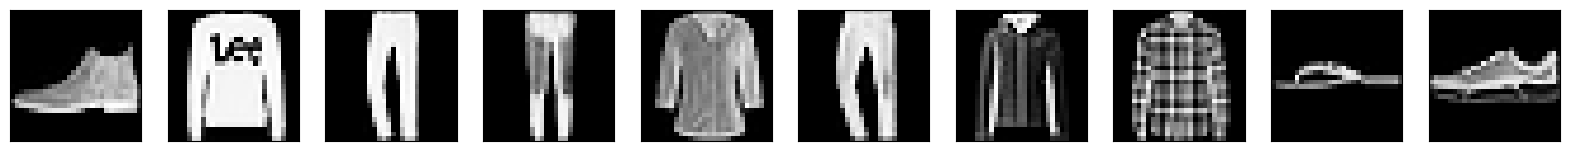

Generated:


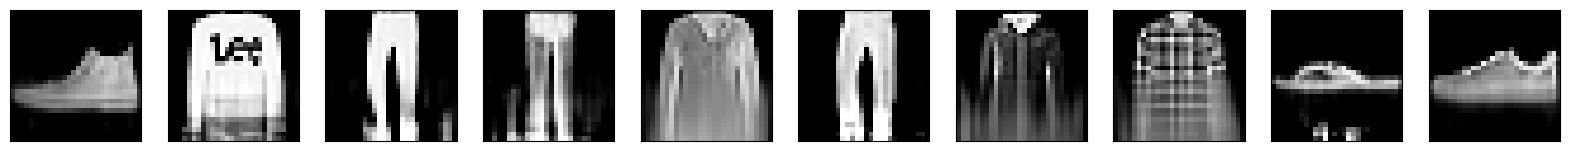

In [12]:
from torch import optim

# 평균 제곱 오차
loss_fnc = nn.MSELoss()

# 최적화 알고리즘
optimizer = optim.Adam(net.parameters())

# 손실의 로그
record_loss_train = []

# 학습
epochs = 50  # 에포크 수
for i in range(epochs):
    net.train()  # 훈련 모드
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # 미니배치 (x, t)를 꺼낸다
        x, t = x.cuda(), t.cuda()  # GPU 대응
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%5==0 or i==epochs-1:
        print("Epoch:", i, "Loss_Train:", loss_train)
        generate_images()

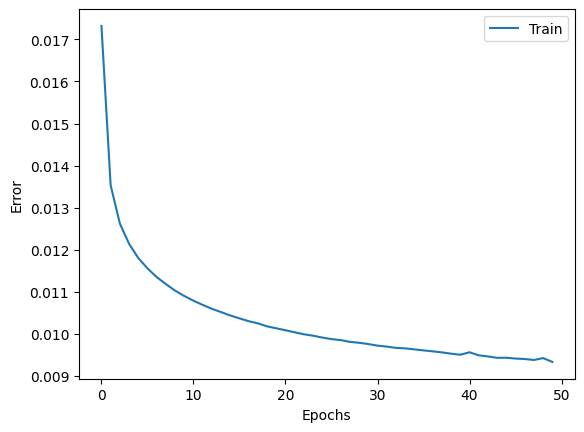

In [13]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()